In [2]:
from __future__ import division

import gym
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim

import trackpy as tp
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import scipy.misc
import os
%matplotlib inline


import cv2

In [72]:
import pdb
from time import sleep

import tensorflow.python.platform
from tensorflow.python.platform import gfile

from PIL import Image
import re

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer

In [55]:
from piaget import Point, Mover, MoverTracker, FramePair, Box, Categorizer
from piaget import init_env, play

In [87]:
env = gym.make('MsPacman-v0'); num_wait_steps=100;
#env = gym.make('Carnival-v0'); num_wait_steps = 1;

[2017-05-12 22:27:49,044] Making new env: MsPacman-v0
/Users/robertfriel/Documents/neural_networks/gym/gym/envs/registration.py:17: DeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [88]:
num_steps = 20
img_dir = 'img/'
mt = play(num_steps, env, img_dir, num_wait_steps)
fp = mt.frame_pairs
frame_thresh = [f.thresh for f in fp]

print mt.game_id

Frame 19: 6 trajectories present
640530


In [89]:
cat = Categorizer(mt.game_id, img_dir, mt.hyperparams)
cat.categorize_movers()

Processing img/640530/mover0/frame0.jpg...
Processing img/640530/mover1/frame19.jpg...
Processing img/640530/mover2/frame0.jpg...
Processing img/640530/mover2/frame2.jpg...
Processing img/640530/mover3/frame17.jpg...
Processing img/640530/mover4/frame9.jpg...
Processing img/640530/mover6/frame2.jpg...
Processing img/640530/mover7/frame9.jpg...
Processing img/640530/mover9/frame12.jpg...


In [90]:
LR=cat.LR
features=cat.features
labels=cat.labels

In [91]:
#np.random.shuffle
labels_rand = labels.copy()
np.random.shuffle(labels_rand)

In [92]:
LB = LabelBinarizer()
lb_labels = LB.fit_transform(labels)

for i in range(max(labels)+1):
    features_i = features[labels == i]
    labels_i = lb_labels[labels == i]
    features_rand_i = features[labels_rand == i]
    print i, 'size', len(labels_i)
    print i, 'log loss', log_loss(labels_i, LR.predict_proba(features_i))
    print i, 'score', LR.score(features_i, labels[labels == i])
    print i, 'rand', log_loss(labels_i, LR.predict_proba(features_rand_i)), '\n'

0 size 1
0 log loss 0.0971743715165
0 score 1.0
0 rand 7.24230329454 

1 size 17
1 log loss 0.352031406615
1 score 0.823529411765
1 rand 4.49630635326 

2 size 18
2 log loss 0.0242887911745
2 score 1.0
2 rand 4.72076265186 

3 size 8
3 log loss 1.48339014269
3 score 0.0
3 rand 4.81773982211 

4 size 5
4 log loss 1.91749616478
4 score 0.0
4 rand 5.02298556361 

5 size 5
5 log loss 1.34578556857
5 score 1.0
5 rand 6.46576599952 

6 size 8
6 log loss 1.48339014269
6 score 0.0
6 rand 2.75932884242 

7 size 7
7 log loss 1.26867143922
7 score 0.857142857143
7 rand 6.10820336524 

8 size 7
8 log loss 0.0644344664631
8 score 1.0
8 rand 4.67567578168 

9 size 10
9 log loss 0.043272082995
9 score 1.0
9 rand 4.42664856356 

10 size 1
10 log loss 0.0617759050414
10 score 1.0
10 rand 6.70443762637 

11 size 1
11 log loss 0.0737877281761
11 score 1.0
11 rand 6.78102707644 



In [52]:
import matplotlib.colors as mcolors
box_colors_rgb = np.array([mcolors.hex2color(v) for v in mcolors.cnames.values()]).reshape((1,147, 3))
box_colors_hsv = mcolors.rgb_to_hsv(box_colors_rgb)
good_indices = (box_colors_hsv[0][:,1] > 0.5) & (box_colors_hsv[0][:,2] < 0.8)

box_colors = box_colors_rgb[0][good_indices]


0



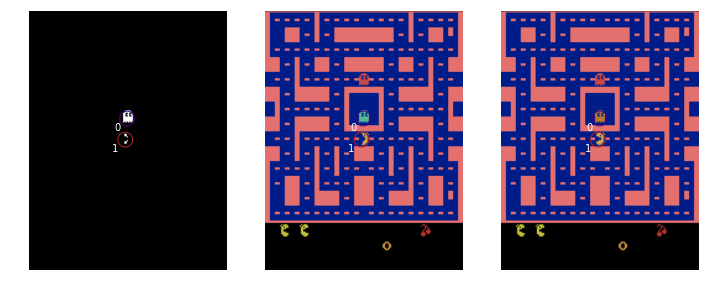


1



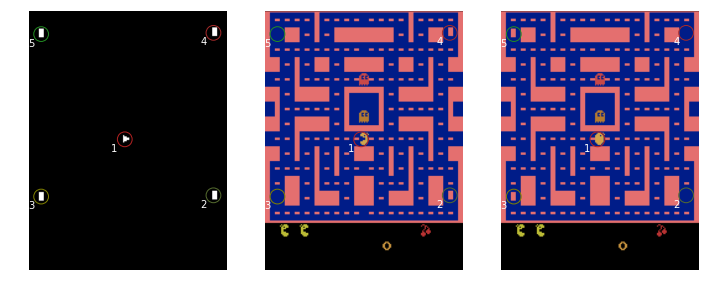


2



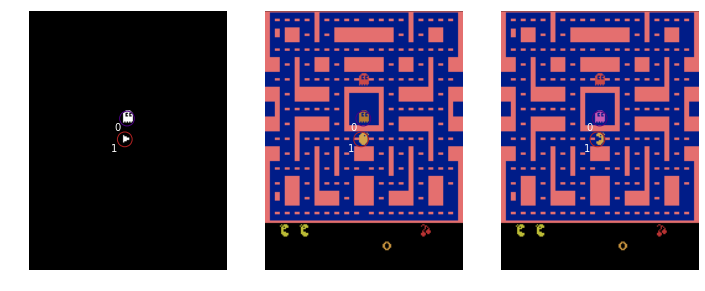


3



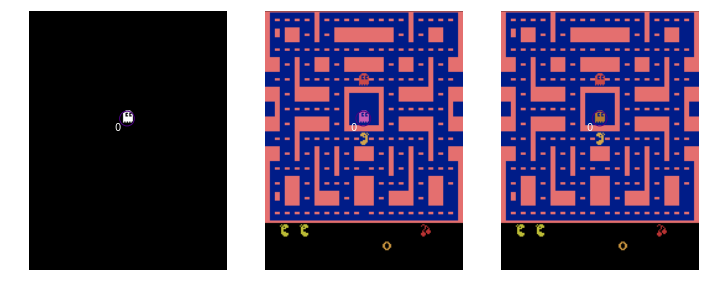


4



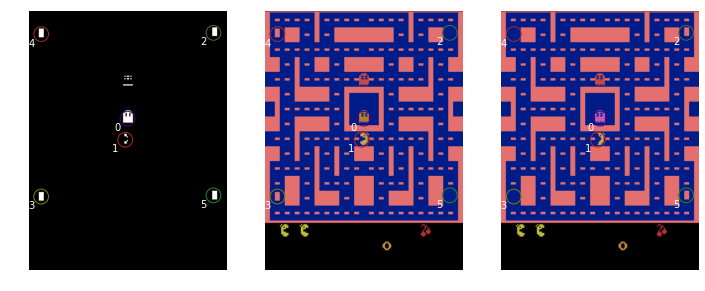


5



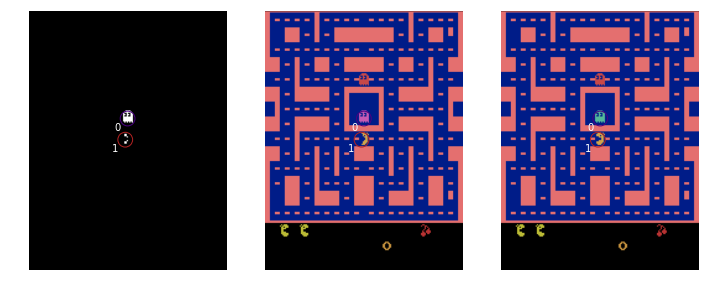


6



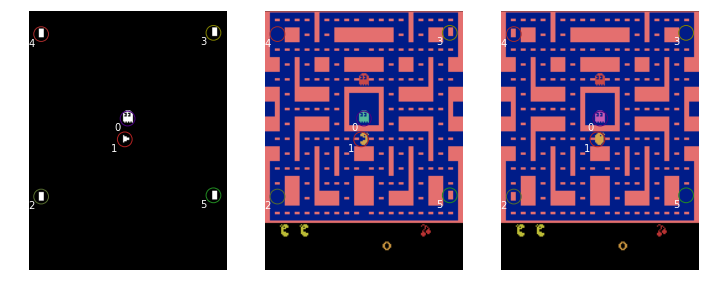


7



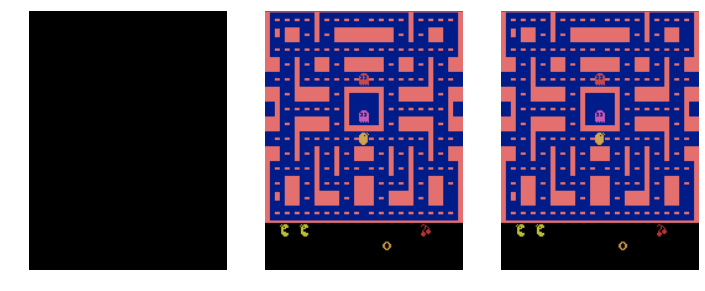


8



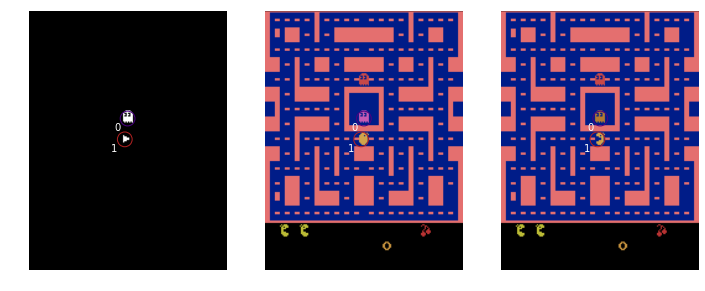


9



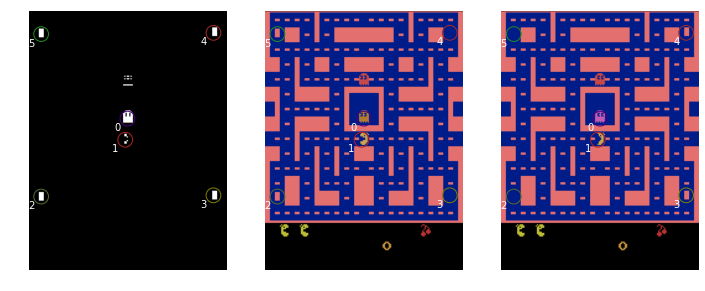


10



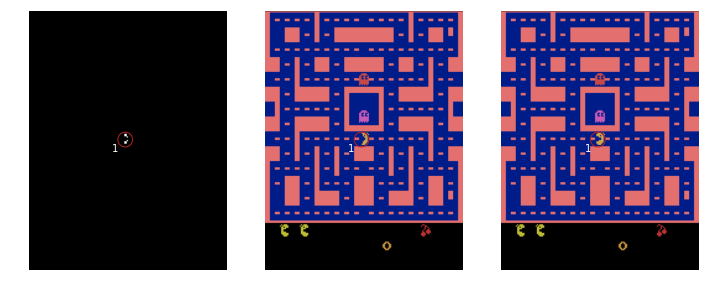


11



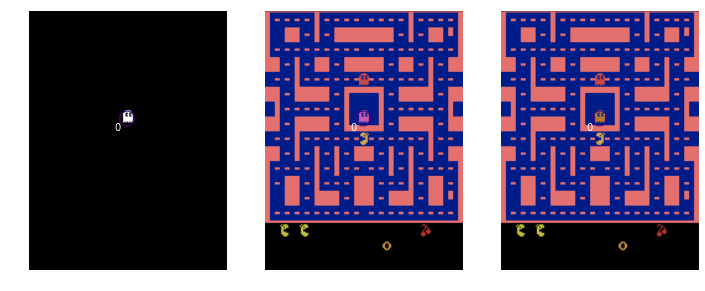


12



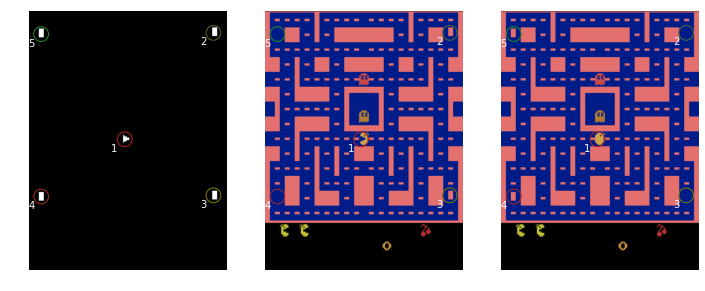


13



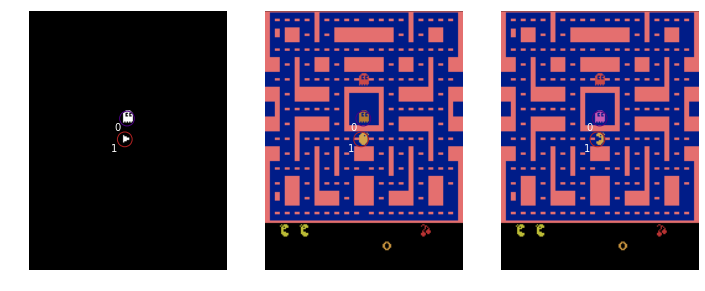


14



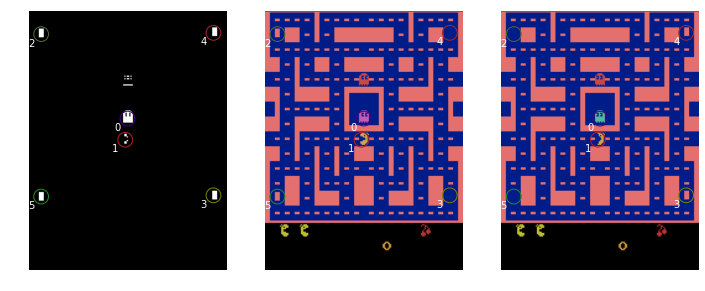


15



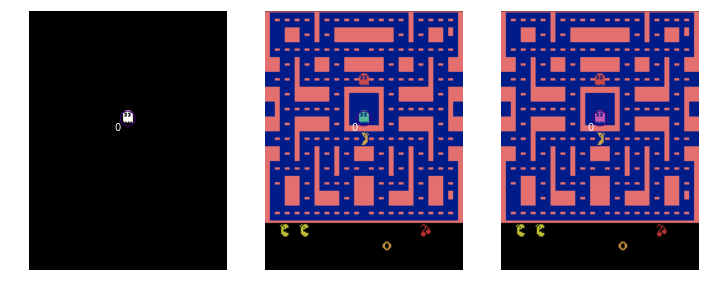


16



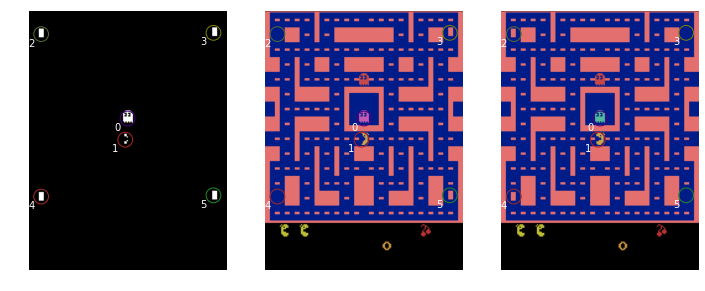


17



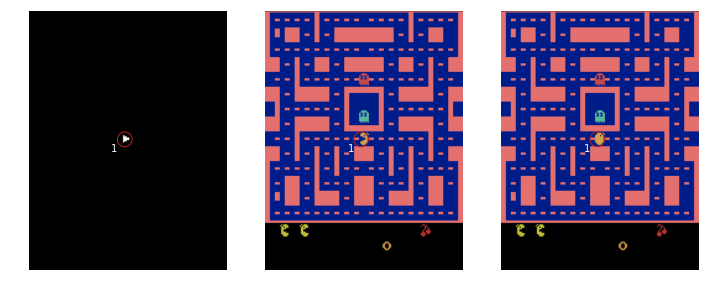


18



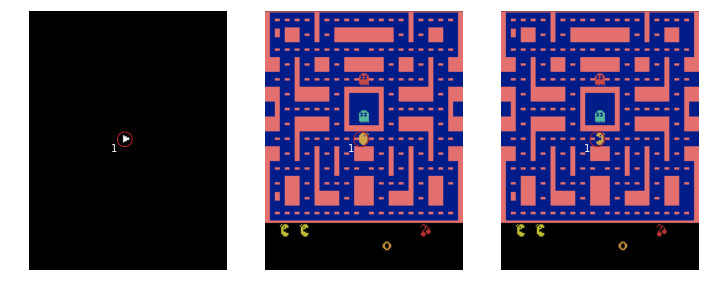


19



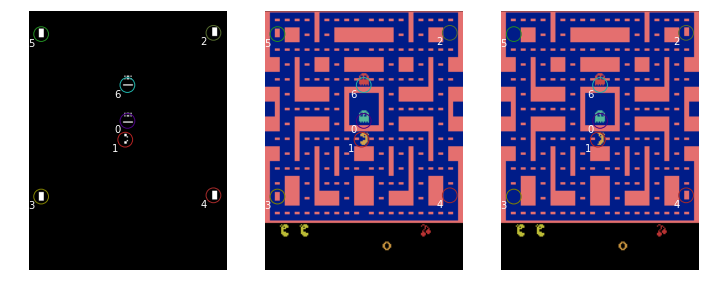

In [53]:
for i, thresh in enumerate(frame_thresh):
    print '\n' + str(i) + '\n'
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(131)
    plt.axis('off')
    plt.imshow(thresh,cmap='gray')
    movers_cur_frame = []
    for m in mt.movers:
        cur_frame_pos = filter(lambda p: p[0]==i, m.trajectory)
        if len(cur_frame_pos) > 0:
            movers_cur_frame.append((m.id, cur_frame_pos[0][1]))
    for data in movers_cur_frame:
        m_id = data[0]
        pos = data[1]
        ax.add_patch(patches.Circle((pos.x, pos.y),
                                    radius=6,
                                    color=box_colors[m_id],
                                    fill=False)
            )
        plt.text(pos.x-10, pos.y+10, str(m_id),color='w')
        
    ax = fig.add_subplot(132)
    plt.axis('off')
    plt.imshow(fp[i].s0)
    for data in movers_cur_frame:
        m_id = data[0]
        pos = data[1]
        ax.add_patch(patches.Circle((pos.x, pos.y),
                                    radius=6,
                                    color=box_colors[m_id],
                                    fill=False)
            )
        plt.text(pos.x-10, pos.y+10, str(m_id),color='w')

    
    ax = fig.add_subplot(133)
    plt.axis('off')
    plt.imshow(fp[i].s1)
    for data in movers_cur_frame:
        m_id = data[0]
        pos = data[1]
        ax.add_patch(patches.Circle((pos.x, pos.y),
                                    radius=6,
                                    color=box_colors[m_id],
                                    fill=False)
            )
        plt.text(pos.x-10, pos.y+10, str(m_id),color='w')

    plt.show()

In [103]:
frame_boxes = [f.boxes for f in fp]
centers = [[b.center  for b in boxes] for boxes in frame_boxes]

pixel_frames = []

for boxes in frame_boxes:
    darkFrame = np.zeros((210,160,3))

    for b in boxes:
        darkFrame[int(b.ll.y):int(b.ur.y), int(b.ll.x):int(b.ur.x), :] = b.img
        
    pixel_frames.append(darkFrame)

In [539]:
for obs in t[t['particle']==1].iterrows():
    print obs[1].frame
    print 

0.0
[0.0, (85.25736568457539, 72.623570190641246)]
1.0
[1.0, (85.348808122424956, 72.791200706297815)]
2.0
[2.0, (82.463022866703852, 70.657445621862806)]
3.0
[3.0, (81.084621872364352, 72.478633680067475)]
4.0
[4.0, (77.0, 72.458223735107538)]
5.0
[5.0, (75.125279475331638, 71.792890147562971)]
8.0
[8.0, (73.80657999469355, 72.6164322985761)]
9.0
[9.0, (73.604567639745838, 78.672345519845294)]


//anaconda/envs/tensorflow/lib/python2.7/site-packages/pandas/core/common.py:277: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  return -res
//anaconda/envs/tensorflow/lib/python2.7/site-packages/pandas/core/common.py:277: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  return -res
//anaconda/envs/tensorflow/lib/python2.7/site-packages/pandas/core/common.py:277: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  return -res
//anaconda/envs/tensorflow/lib/python2.7/site-packages/pandas/core/common.py:277: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  return -res
//anaconda/envs/tensorflow/lib/python2.7/site-packages/pandas/core/common.py

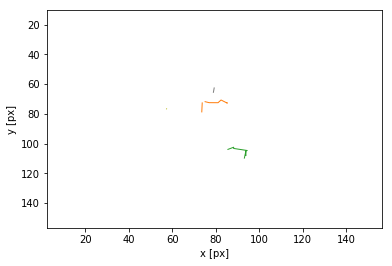

In [524]:
tp.plot_traj(t)

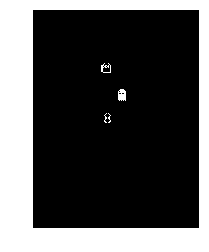

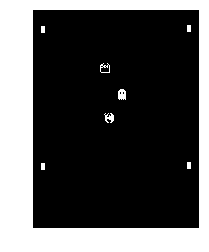

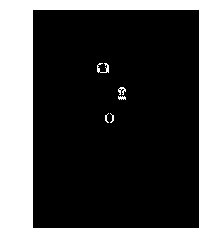

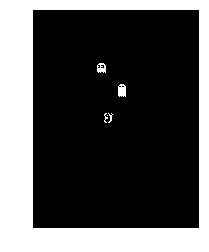

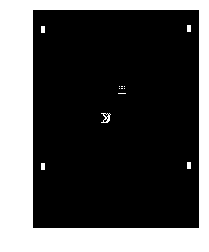

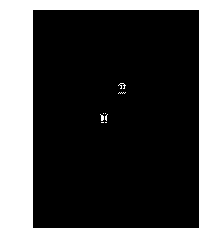

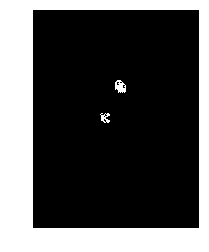

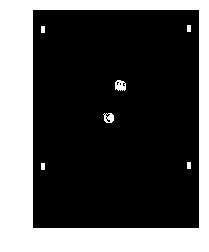

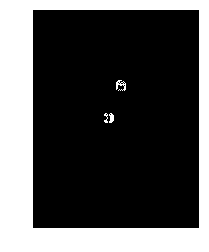

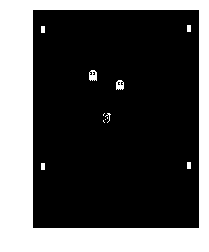

In [405]:
for thresh in frame_thresh:
    plt.figure()
    plt.axis('off')
    plt.imshow(thresh,cmap='gray')

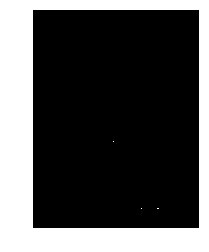

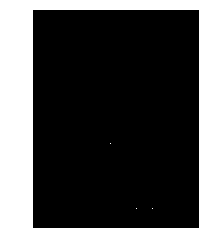

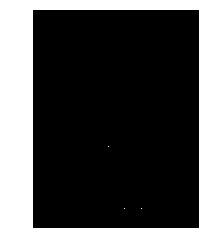

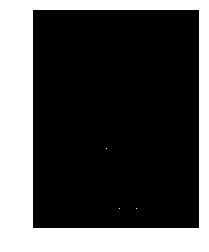

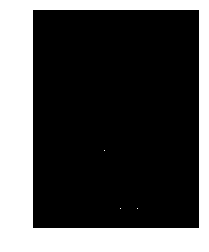

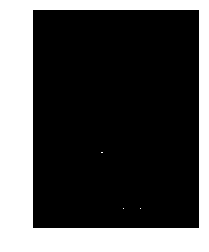

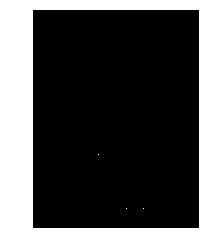

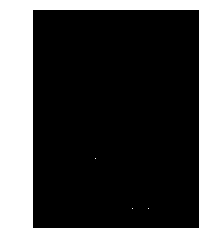

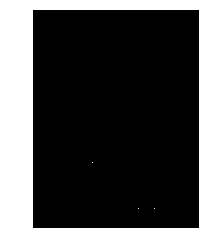

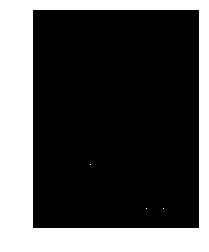

In [233]:
frame_boxes = [f.boxes for f in fp]
centers = [[b.center  for b in boxes] for boxes in frame_boxes]

for frame_centers in centers:
    plt.figure()
    plt.axis('off')
    darkFrame = np.zeros((210,160,3))

    for c in frame_centers:
        darkFrame[int(c.y), int(c.x), :] = 1

    plt.imshow(darkFrame)

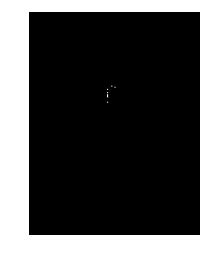

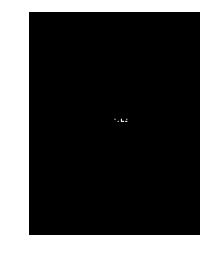

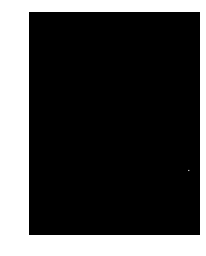

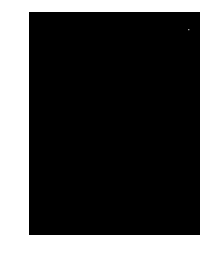

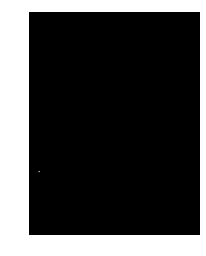

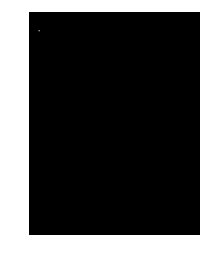

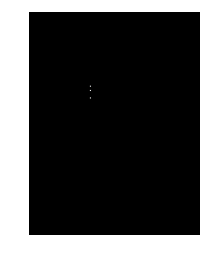

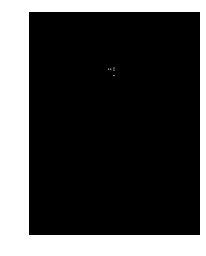

In [107]:
for m in mt.movers:
    plt.figure()
    plt.axis('off')
    darkFrame = np.zeros((210,160,3))

    for p in m.trajectory:
        darkFrame[int(p[1].y), int(p[1].x), :] = 1

    plt.imshow(darkFrame)

0.368421052632


"\nLR3 = LogisticRegression(penalty='l1', C=0.5)\nLR3.fit(features[400:], action_targets[400:])\nprint LR3.score(features[400:], action_targets[400:])\nplt.matshow(LR3.coef_,cmap='gray')\nplt.colorbar()\n"

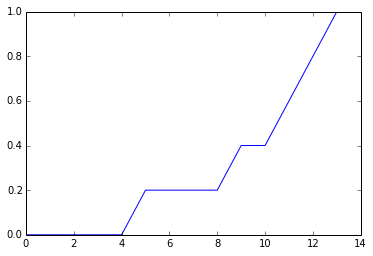

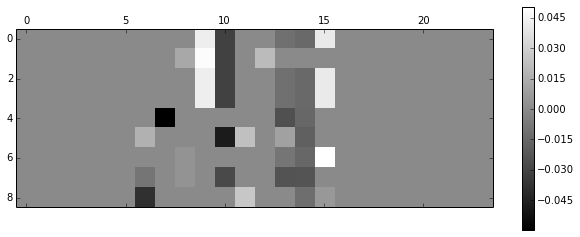

In [102]:
# messing around
test = mt.movers
traj = [t.trajectory for t in test]

disp = []
acc = []
for tt in traj:
    t = [tup[1] for tup in tt]
    disp_pts = [p2 - p1 for p2, p1 in zip(t[1:],t[:-1])]
    acc_pts = [p2 - p1 for p2, p1 in zip(disp_pts[1:],disp_pts[:-1])]
    disp_x = [p.x for p in disp_pts]
    disp_y = [p.y for p in disp_pts]
    acc_x = [p.x for p in acc_pts]
    acc_y = [p.y for p in acc_pts]

    disp.append(disp_x)
    disp.append(disp_y)
    acc.append(acc_x)
    acc.append(acc_y)

disp_features = np.array([np.concatenate([np.zeros(len(mt.action_hist[:-1])-len(d)), np.array(d)]) for d in disp]).T

acc_features = np.array([np.concatenate([np.zeros(len(mt.action_hist[:-1])-len(d)), np.array(d)]) for d in acc]).T

action_targets = np.array(mt.action_hist[1:])
features = disp_features


LR2 = LogisticRegression(penalty='l1', C=0.1)
LR2.fit(features, action_targets)
print LR2.score(features, action_targets)
#plt.matshow(LR2.coef_,cmap='gray')
plt.plot([LR2.score(features[i:i+5], action_targets[i:i+5]) for i in range(action_targets.shape[0]-5)])

plt.matshow(LR2.coef_,cmap='gray')
plt.colorbar()

'''
LR3 = LogisticRegression(penalty='l1', C=0.5)
LR3.fit(features[400:], action_targets[400:])
print LR3.score(features[400:], action_targets[400:])
plt.matshow(LR3.coef_,cmap='gray')
plt.colorbar()
'''